In [ ]:
import random

# Set the random seed to a specific value
random.seed(1234)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/Computer Vision/coursework"

Mounted at /content/drive


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Video', 'Code', 'CW_Dataset', 'Models', 'test_functions.ipynb']


# Load The dataset to colab 
In this section we unzip the provided dataset and put the images in the "dataset" folder in colab directory. This Folder contains two subfolders, "test" and "train". Each of these subfolders contains three folders "0" , "1", "2"  0 if no mask
is worn, 1 if it is worn, and 2 if it is worn improperly.

In [ ]:
import os
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip

In [ ]:
import os
import shutil


# Define path to train folder inside the dataset
#train_path = os.path.join(dataset_path, "train")
train_path = "./train/"


# Define path to the labels folder inside the train folder
train_labels_path = os.path.join(train_path, "labels")

# Define path to the images folder inside the train folder
train_images_path = os.path.join(train_path, "images")

# Create the folders for each class (0, 1, 2) inside the train folder
for class_id in range(3):
    class_path = os.path.join(train_path, str(class_id))
    os.makedirs(class_path, exist_ok=True)

# Loop through each image in the train images folder and move them to the appropriate class folder
for image_name in os.listdir(train_images_path):
    image_path = os.path.join(train_images_path, image_name)
    label_path = os.path.join(train_labels_path, image_name[:-5] + ".txt")  
    with open(label_path, "r") as f:
        label = int(f.read())
    class_path = os.path.join(train_path, str(label))
    shutil.move(image_path, os.path.join(class_path, image_name))

In [ ]:

# Define path to test folder inside the dataset
test_path = "./test/"

# Define path to the labels folder inside the test folder
test_labels_path = os.path.join(test_path, "labels")

# Define path to the images folder inside the test folder
test_images_path = os.path.join(test_path, "images")

# Create the folders for each class (0, 1, 2) inside the test folder
for class_id in range(3):
    class_path = os.path.join(test_path, str(class_id))
    os.makedirs(class_path, exist_ok=True)

# Loop through each image in the test images folder and move them to the appropriate class folder
for image_name in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_name)
    label_path = os.path.join(test_labels_path, image_name[:-5] + ".txt")  
    with open(label_path, "r") as f:
        label = int(f.read())
    class_path = os.path.join(test_path, str(label))
    shutil.move(image_path, os.path.join(class_path, image_name))


In [ ]:
# Delete the images and labels folders inside the train and test folders
shutil.rmtree(train_images_path)
shutil.rmtree(train_labels_path)
shutil.rmtree(test_images_path)
shutil.rmtree(test_labels_path)

In [ ]:
import os


# Get the current directory
current_dir = os.getcwd()

# Print the current directory
print("Current Directory: ", current_dir)

#shutil.rmtree('dataset')

## Create the directory
os.mkdir('dataset')

shutil.move('/content/test','/content/dataset')
shutil.move('/content/train','/content/dataset')


Current Directory:  /content


'/content/dataset/train'

# HOG SVM 

### Libraries 

In [ ]:
# import the necessary libraries
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import confusion_matrix
import random
import os
from sklearn import metrics
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import AffineTransform, warp
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn import svm
import pickle
from skimage import io



### Class count

In [ ]:
train_path = 'dataset/train'
class_count = {}

# Iterate through the folders in the train path
for folder in os.listdir(train_path):
    folder_path = os.path.join(train_path, folder)
    class_count[folder] = len(os.listdir(folder_path))

minority_class = min(class_count, key=class_count.get)

print("Minority Class:", minority_class)
print("Number of examples in minority class:", class_count[minority_class])
print("Number of samples in each Class", class_count)

Minority Class: 2
Number of examples in minority class: 78
Number of samples in each Class {'0': 376, '1': 1940, '2': 78}


As we can see we have class imbalance in class 0 and 2 as minority. We will performe data augmetation on these classes to address this issue.

### preprocessing 



In this section wil prepare the train dataset for a machine learning model by extracting HOG features from images, performing data augmentation for minorty classes, and applying feature scaling and normalization.

### parameters 


In [ ]:
# set up the paths for the dataset
train_path = 'dataset/train'
test_path = 'dataset/test'

img_size = (32,32)

# parameters for the HOG feature descriptor
orientations = 9
pixels_per_cell = (4, 4)
cells_per_block = (2, 2)
visualize = False
transform_sqrt = False
#channel_axis=2 #color

# parameters for data augmentation
augmentation_enabled = True
augmentation_factor = 5

the following functions are used for preprocessing and augmenting images and balancing the labels for a machine learning model. The **augment_image** function takes an image and its corresponding label as input, and performs data augmentation on the image by rotating it by a random angle between -20 and 20 degrees, and flipping it horizontally with a 50% probability. It returns a list of augmented images. The **preprocess_train** function takes a path to the training dataset as input, and extracts the Histogram of Oriented Gradient (HOG) features from the images. It also performs data augmentation on specified classes using the augment_image function. The features and labels are then combined, shuffled, and scaled before returning. The preprocess_testset function is similar to preprocess_train, but it is used for the test dataset. The **visualize_hog_features** function is used for visualizing the HOG features of images from a specified class for visualization purposes.

In [ ]:
def augment_image(image, label):
    if label == 0:
        augmentation_factor = 5
    elif label == 2:
        augmentation_factor = 24
    else:
        augmentation_factor = 5  # default value
        
    augmented_images = []
    for i in range(augmentation_factor):
        # Rotate by a random angle between -20 and 20 degrees
        angle = random.randint(-20, 20)
        rotated_image = np.array(Image.fromarray(image).rotate(angle))
        
        # Flip horizontally with 50% probability
        flip_prob = random.random()
        if flip_prob < 0.5:
            rotated_image = np.fliplr(rotated_image)
            
        augmented_images.append(rotated_image)
    return augmented_images


#########################################################

def preprocess_trainset(train_path):
  # Extract the HOG features from the training dataset
  train_features = []
  train_labels = []

  # Define the classes for which data augmentation will be performed
  augmentation_classes = ['0', '2']

  for folder in os.listdir(train_path):
      folder_path = os.path.join(train_path, folder)
      label = int(folder)
      for filename in os.listdir(folder_path):
          image_path = os.path.join(folder_path, filename) 
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, img_size)
          
          # Perform data augmentation only for classes in the augmentation_classes list and when augmentation_enabled is True
          if augmentation_enabled and str(label) in augmentation_classes:
              augmented_images = augment_image(image,label)
              for augmented_image in augmented_images:
                  fd = hog(augmented_image, orientations=orientations,
                          pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                          visualize=visualize, transform_sqrt=transform_sqrt)
                  train_features.append(fd)
                  train_labels.append(label)
          
          fd = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                  visualize=visualize, transform_sqrt=transform_sqrt)
          train_features.append(fd)
          train_labels.append(label)


  # combine the features and labels into a single list
  data = list(zip(train_features, train_labels))

  # shuffle the data
  random.shuffle(data)

  # separate the shuffled features and labels into separate lists
  train_features, train_labels = zip(*data)

  # perform feature scaling and normalization
  train_features = np.array(train_features)
  train_features = (train_features - np.mean(train_features)) / np.std(train_features)

  return train_features, train_labels

#########################################################

def preprocess_testset(test_path):
  # extract the HOG features from the test dataset
  test_features = []
  test_labels = []
  for folder in os.listdir(test_path):
      folder_path = os.path.join(test_path, folder)
      label = int(folder)
      for filename in os.listdir(folder_path):
          image_path = os.path.join(folder_path, filename)
          image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
          image = cv2.resize(image, img_size)
          fd= hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
                  visualize=visualize, transform_sqrt=transform_sqrt)
          test_features.append(fd)
          test_labels.append(label)

  # perform feature scaling and normalization on test
  test_features = np.array(test_features)
  test_features = (test_features - np.mean(test_features)) / np.std(test_features)
  return test_features, test_labels


#########################################################

def visualize_hog_features(train_path, img_size=(256, 256), orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(1, 1), visualize=True, transform_sqrt=False, num_samples=5):
    # Counter to keep track of images processed for visualization
    visualization_counter = 0

    for folder in ['2']:
        folder_path = os.path.join(train_path, folder)
        label = int(folder)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, img_size)

            fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                cells_per_block=cells_per_block,
                                visualize=visualize, transform_sqrt=transform_sqrt)
            if visualize and visualization_counter < num_samples:
                plt.figure()
                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title('Original Image for Label: {}'.format(label))

                plt.figure()
                plt.imshow(hog_image, cmap='gray')
                plt.title('HOG Features Visualization for Label: {}'.format(label))
                plt.show()
                visualization_counter += 1


### class balanace after augmentation for the minority classes.
As we can see now we have almost the same amount of samples for each class after augmentation for minority class.

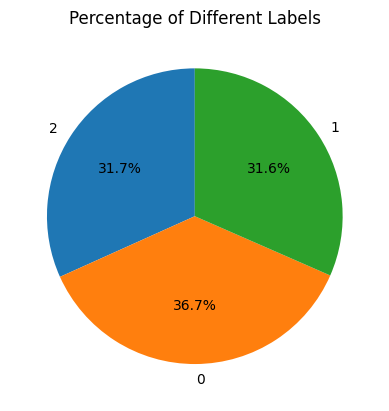

In [ ]:
train_features, train_labels = preprocess_trainset(train_path)

# Calculate percentage of each label
total_labels = len(train_labels)
label_counts = {}
for label in train_labels:
    if label not in label_counts:
        label_counts[label] = 1
    else:
        label_counts[label] += 1

label_percentages = [count/total_labels*100 for count in label_counts.values()]

# Create pie chart
labels = label_counts.keys()
plt.pie(label_percentages, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Different Labels')
plt.show()

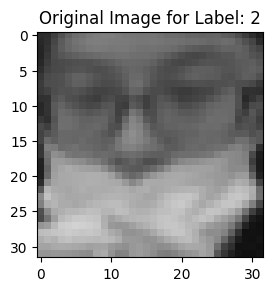

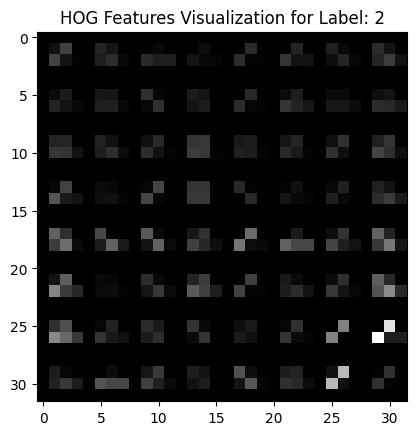

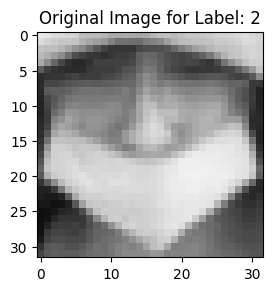

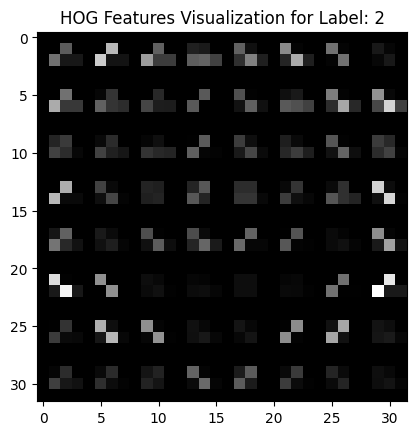

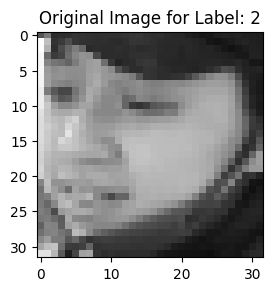

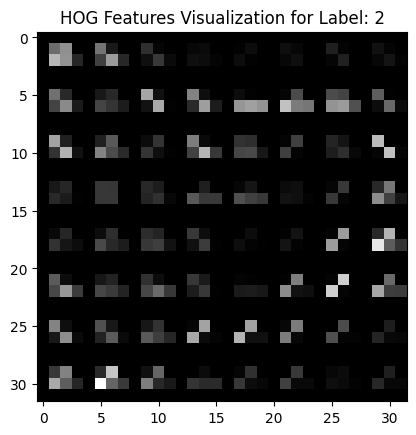

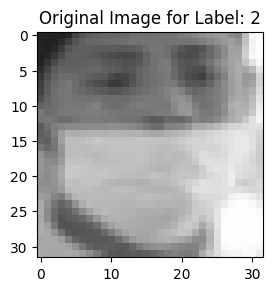

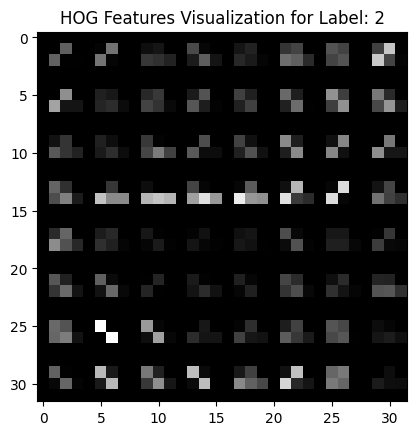

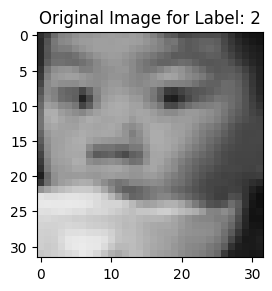

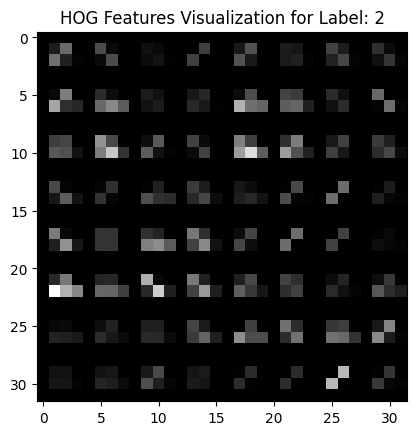

In [ ]:
visualize_hog_features(train_path, img_size=(32,32), orientations=9, pixels_per_cell=(4, 4),
                            cells_per_block=(1, 1), visualize=True, transform_sqrt=False, num_samples=5)

In [ ]:
len(train_features[1])

1764

### Training (CVgridsearch)

In [ ]:
# ptreprocessing dataset 

train_features, train_labels = preprocess_trainset(train_path)
test_features, test_labels = preprocess_testset(test_path)


In [ ]:


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the hyperparameter grid for grid search
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear','rbf']}

# Create an SVM classifier
clf = svm.SVC()

# Perform grid search cross-validation
grid_search = GridSearchCV(clf, param_grid, cv=3,refit=True, n_jobs=-1,scoring = 'accuracy') 
grid_search.fit(train_features, train_labels)

# Get the best parameters and best score from grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)


Best Parameters:  {'C': 10, 'kernel': 'rbf'}
Best Score:  0.9210293816069287


### Save model 

In [ ]:

model_SVM_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','gridsearch_svm.pickle')

# Save the gs instance to a file
with open(model_SVM_path, 'wb') as f:
  pickle.dump(grid_search, f)



### load model

In [ ]:
import pickle
model_SVM_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','gridsearch_svm.pickle')

#Load the gs instance from the file
with open(model_SVM_path, 'rb') as f:
  grid_search = pickle.load(f)

### Test the classifier on the test set & confusion matrix& predict time




Time elapsed: 2.92 seconds
Classification report for classifier GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
             scoring='accuracy'):
                    precision    recall  f1-score   support

           0       0.60      0.71      0.65        51
           1       0.94      0.93      0.93       388
           2       0.39      0.37      0.38        19

    accuracy                           0.88       458
   macro avg       0.64      0.67      0.65       458
weighted avg       0.88      0.88      0.88       458




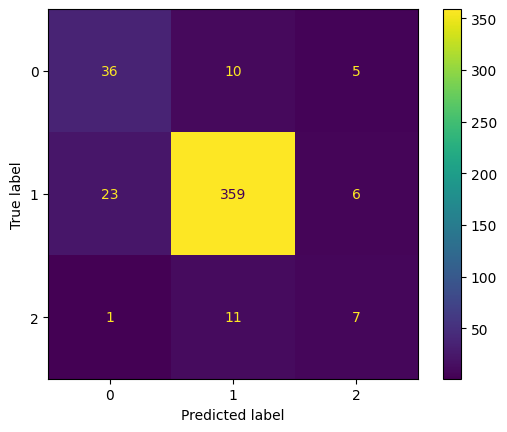

[70.58823529 92.5257732  36.84210526]


In [ ]:

import time

start_time = time.time()

predictions = grid_search.predict(test_features)

end_time = time.time()

# Time elapsed
elapsed_time = end_time - start_time
print("Time elapsed: {:.2f} seconds".format(elapsed_time))

print(f"""Classification report for classifier {grid_search}:
      {metrics.classification_report(test_labels, predictions)}\n""")
metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predictions)
plt.show()



from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(test_labels, predictions)
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)


# MLP + HOG 

###  preprocessing 

In [ ]:
# preprocess the dataset
X_train, y_train = preprocess_trainset(train_path)
X_test, y_test = preprocess_testset(test_path)


### Train MLP

In [ ]:
from sklearn.neural_network import MLPClassifier 
# Create a classifier: Multi-Layer Perceptron
classifier = MLPClassifier(hidden_layer_sizes=(100,50), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=True, random_state=123,
                    learning_rate_init=.003, early_stopping=True, learning_rate='constant')

classifier.fit(X_train, y_train)

Iteration 1, loss = 1.03655151
Validation score: 0.656911
Iteration 2, loss = 0.61217856
Validation score: 0.725203
Iteration 3, loss = 0.46613769
Validation score: 0.760976
Iteration 4, loss = 0.37632685
Validation score: 0.798374
Iteration 5, loss = 0.30918665
Validation score: 0.817886
Iteration 6, loss = 0.25623282
Validation score: 0.837398
Iteration 7, loss = 0.21458992
Validation score: 0.853659
Iteration 8, loss = 0.18117922
Validation score: 0.866667
Iteration 9, loss = 0.15203375
Validation score: 0.873171
Iteration 10, loss = 0.12856031
Validation score: 0.874797
Iteration 11, loss = 0.10901259
Validation score: 0.876423
Iteration 12, loss = 0.09271871
Validation score: 0.881301
Iteration 13, loss = 0.07936742
Validation score: 0.879675
Iteration 14, loss = 0.06764293
Validation score: 0.886179
Iteration 15, loss = 0.05826144
Validation score: 0.884553
Iteration 16, loss = 0.05015610
Validation score: 0.881301
Iteration 17, loss = 0.04367529
Validation score: 0.884553
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 50),
              learning_rate_init=0.003, max_iter=100, random_state=123,
              solver='sgd', verbose=True)

### save model

In [ ]:
model_MLP_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','MLP.pickle')
import pickle

# Save the instance to a file
with open(model_MLP_path, 'wb') as f:
  pickle.dump(classifier, f)



### load model

In [ ]:
model_MLP_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','MLP.pickle')

#Load the instance from the file
with open(model_MLP_path, 'rb') as f:
  classifier = pickle.load(f)


### Test the MLP classifier on the test set & confusion matrix& predict time

In [ ]:
import time

start_time = time.time()

y_pred = classifier.predict(X_test)

end_time = time.time()

# Time elapsed
elapsed_time = end_time - start_time
print("Time elapsed: {:.2f} seconds".format(elapsed_time))

Time elapsed: 0.02 seconds


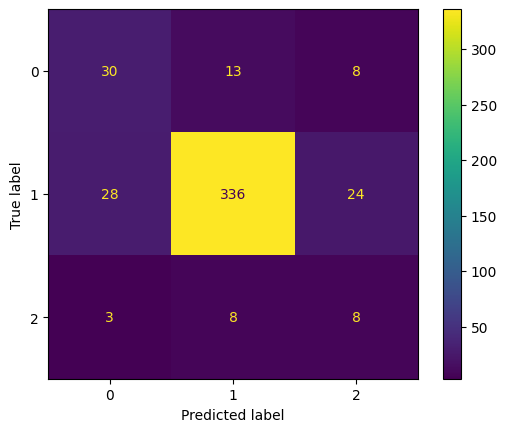

[58.82352941 86.59793814 42.10526316]


In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test, y_pred)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

In [ ]:
print(f"""Classification report for classifier {classifier}:\n
      {metrics.classification_report(y_test, y_pred)}""")

Classification report for classifier MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 50),
              learning_rate_init=0.003, max_iter=100, random_state=123,
              solver='sgd', verbose=True):

                    precision    recall  f1-score   support

           0       0.49      0.59      0.54        51
           1       0.94      0.87      0.90       388
           2       0.20      0.42      0.27        19

    accuracy                           0.82       458
   macro avg       0.54      0.63      0.57       458
weighted avg       0.86      0.82      0.84       458

